In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model

In [2]:
SIZE = 224

In [10]:
PATH = r'D:\ML DEEP LEARNING FACE\Masked Face Recognition\data\MaskImages'
PATH

'D:\\ML DEEP LEARNING FACE\\Masked Face Recognition\\data\\MaskImages'

In [33]:
# Training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob(os.path.join(PATH,"*")):
    label = directory_path.split("\\")[-1]
    # print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [13]:
np.save('train_images.npy',train_images)
np.save('train_labels.npy',train_labels)

In [14]:
train_images=np.load('train_images.npy')
train_labels=np.load('train_labels.npy')

In [34]:
#Encode labels from text to integers.
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)

In [32]:
train_labels_encoded

array([1, 1, 1, ..., 0, 0, 0])

In [35]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(train_images,train_labels_encoded,shuffle=True,test_size=0.2)

In [36]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [37]:
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [39]:
# Loading model
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
for layer in VGG_model.layers:
	layer.trainable = False
    
x=Flatten()(VGG_model.output)
VGG_model = Model(inputs=VGG_model.input, outputs=x)
# VGG_model.summary()

In [40]:
features=VGG_model.predict(x_train)

93/93 [==============================] - 648s 7s/step


In [51]:
VGG_model.save('featuresVGGDetector.h5')

In [41]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 100, random_state = 40)

In [43]:
RF_model.fit(features, y_train)

RandomForestClassifier(random_state=40)

In [50]:
import joblib
joblib.dump(RF_model, "RFModelDetector.joblib")

['RFModelDetector.joblib']

In [45]:
X_test_features = VGG_model.predict(x_test)

24/24 [==============================] - 165s 7s/step


In [46]:
prediction_RF = RF_model.predict(X_test_features)

In [ ]:
#Inverse transform to get original label back. 
prediction_RF = encoder.inverse_transform(prediction_RF)

In [47]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

Accuracy =  0.9676113360323887


<AxesSubplot:>

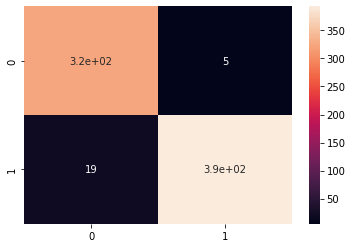

In [48]:
#Confusion Matrix - accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_RF)
sns.heatmap(cm, annot=True)